##Mounting the google drive

In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
pwd

'/content'

##Import Libraries

In [0]:
import os
import cv2
import random
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tqdm
import keras
import keras.layers
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.models import Model
import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, concatenate, BatchNormalization, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

## Clear model parameters before next experiment

In [0]:
tf.reset_default_graph()
K.clear_session()

Paths to Training Directory (Pneumonia & Normal)

In [0]:
train_normal =  Path("../content/drive/My Drive/Colab Notebooks/chest_xray/train/NORMAL/").glob('*.jpeg')
train_pneumonia =  Path("../content/drive/My Drive/Colab Notebooks/chest_xray/train/PNEUMONIA/").glob('*.jpeg')

In [0]:
#Creating a list of all the images
train_images = []

train_normal =  Path("../content/drive/My Drive/Colab Notebooks/chest_xray/train/NORMAL/").glob('*.jpeg')

for img in train_normal:
    train_images.append(img)
    
train_pneumonia =  Path("../content/drive/My Drive/Colab Notebooks/chest_xray/train/PNEUMONIA/").glob('*.jpeg')    
for img in train_pneumonia:
    train_images.append(img)

###Use Image_Process to create X and their y labels

In [0]:
def image_process(imagelist): 
  X=[]
  y=[]
  
  #Use tqdm within loop to visualize progress with a progress bar
  for img in tqdm(imagelist):
    #If image is from the Normal directory, label = 0
    if 'NORMAL' in str(img):
      y.append(0)
    #If image is from the Pneumonia directory, label = 1  
    else:
      y.append(1)
    #Read the image using OpenCV, resize them to 224,224 & use Inter_area to resample using pixel area relation
    X.append(cv2.resize(cv2.imread(str(img),
                                   cv2.IMREAD_COLOR),(224,224),
                        interpolation=cv2.INTER_AREA)) 
  
  
  return X,y

In [8]:
X,y = image_process(train_images)

100%|██████████| 5216/5216 [41:02<00:00,  2.56it/s]


In [0]:
from keras.utils import to_categorical
#X & y to a numpy array
X = np.array(X)
y= np.array(y)

"""
Make y categorical, i.e one hot encoding --> Normal[1,0], Pneumonia[0,1]
Ex: Patient 1 is normal & Patient 2 is infected

           Normal       Pneumonia
Patient 1 |   1              0
Pateint 2 |   0              1
......
"""

y= to_categorical(y)

## Split the data into 90% training & 10% validation

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X,y,test_size=0.1,random_state=2)

print('shape of training img is :',X_train.shape)
print('shape of validation img is :',X_validate.shape)
print('shape of labels :',y_train.shape)
print('shape of labels :',y_validate.shape)


shape of training img is : (4694, 224, 224, 3)
shape of validation img is : (522, 224, 224, 3)
shape of labels : (4694, 2)
shape of labels : (522, 2)


###Check validation data split

In [0]:
v_data_split = pd.DataFrame(y_validate, columns=['normal','pneumonia'])

In [13]:
v_data_split['pneumonia'].value_counts()

1.0    379
0.0    143
Name: pneumonia, dtype: int64

## Applying Adaptive histogram equalization & contrast limited adaptive histogram equalization (CLAHE) to improve contrast in x rays

###NOT USED IN TRAINING ANYMORE

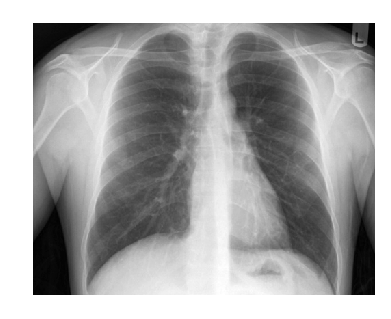

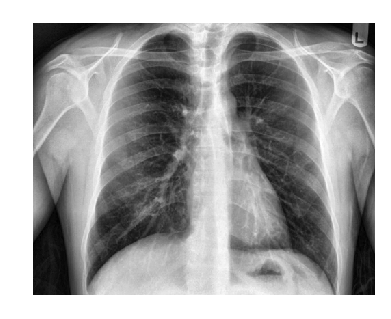

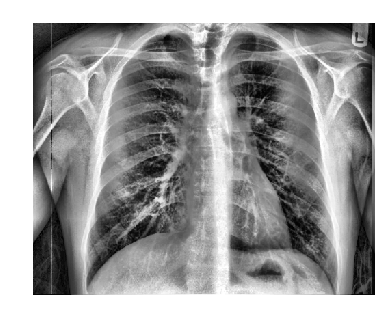

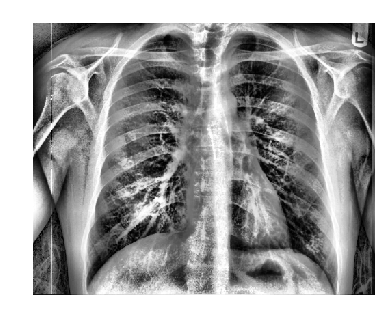

"plt.figure(figsize=(8,5))\nplt.imshow(img)\nplt.title('After Clahe & adapthist', color='white')\nplt.axis('off')\nplt.show()"

In [0]:
from skimage import exposure
img = cv2.imread((str('../content/drive/My Drive/Colab Notebooks/chest_xray/test2.jpg')))
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray_image)
img_adapteq1 = exposure.equalize_adapthist(gray_image, clip_limit=0.03)
img_adapteq = exposure.equalize_adapthist(cl1, clip_limit=0.03)

#plt.subplot()
plt.figure(figsize=(8,5))
plt.imshow(gray_image, cmap='gray')
plt.title('before', color='white')
plt.axis('off')
plt.show()
plt.figure(figsize=(8,5))
plt.imshow(cl1, cmap='gray')
plt.title('AFTER Clahe', color='white')
plt.axis('off')
plt.show()
plt.figure(figsize=(8,5))
plt.imshow(img_adapteq1, cmap='gray')
plt.title('After adapthist', color='white')
plt.axis('off')
plt.show()
plt.figure(figsize=(8,5))
plt.imshow(img_adapteq, cmap='gray')
plt.title('After Clahe & adapthist', color='white')
plt.axis('off')
plt.show()

##Image processing using ImageGenerator
### Only training data is augmented using zoom, brightness

In [0]:
from keras.preprocessing.image import ImageDataGenerator #Data augmentation and preprocessing

train_datagen = ImageDataGenerator(zoom_range=[0.5,1.0],brightness_range=[0.2,1.0],rescale = 1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_gen= train_datagen.flow(X_train, y_train, batch_size=16)
val_gen = val_datagen.flow(X_validate, y_validate, batch_size=16)

In [0]:
def train_data_gen(x,y):
  return train_datagen.flow(x,y,batch_size=16)

In [0]:
def val_data_gen(x,y):
  return val_datagen.flow(x,y,batch_size=16)

##Novel Architecture 1

In [0]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    
    x = MaxPooling2D((2,2), name='pooling')(x)
    
    x = Flatten(name='flatten')(x)
    
    x = Dropout(0.5, name='dropout')(x)
    
    x = Dense(2, activation='softmax', name='Final')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

##Novel Architecture 2 (Uses Depthwise Separable Convolutions)

In [0]:
def build_model():
  
    input_img = Input(shape=(224,224,3), name='ImageInput')
    
   #######################################|Block 1|########################################################

    x1 = Conv2D(32, (3,3), activation='relu', padding='same', name='B1_Conv1')(input_img)
    x2 = SeparableConv2D(32, (3,3), activation='relu', padding='same', name='B1_SConv1')(input_img) 
    x1 = Conv2D(32, (3,3), activation='relu', padding='same', name='B1_Conv2')(x1)
    x2 = SeparableConv2D(32, (3,3), activation='relu', padding='same', name='B1_SConv2')(x2) 
    
    x1 = BatchNormalization()(x1)
    x2 = BatchNormalization()(x2)

    
    x1 = MaxPooling2D((2,2), name='poolingb1c')(x1)
    x2 = MaxPooling2D((2,2), name='poolingb1s')(x2)
    
   #######################################|Block 2|#########################################################
    
    x1 = Conv2D(64, (3,3), activation='relu', padding='same', name='B2_Conv1')(x1)
    x2 = SeparableConv2D(64, (3,3), activation='relu', padding='same', name='B2_SConv1')(x2) 
    x1 = Conv2D(64, (3,3), activation='relu', padding='same', name='B2_Conv2')(x1)
    x2 = SeparableConv2D(64, (3,3), activation='relu', padding='same', name='B2_SConv2')(x2) 
    
    x1 = BatchNormalization()(x1)
    x2 = BatchNormalization()(x2)

    
    x1 = MaxPooling2D((2,2), name='poolingb2c')(x1)
    x2 = MaxPooling2D((2,2), name='poolingb2s')(x2)
    
   #######################################|Block 3|##########################################################
    
    x1 = Conv2D(128, (3,3), activation='relu', padding='same', name='B3_Conv1')(x1)
    x2 = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='B3_SConv1')(x2) 
    x1 = Conv2D(128, (3,3), activation='relu', padding='same', name='B3_Conv2')(x1)
    x2 = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='B3_SConv2')(x2) 
    
    x1 = BatchNormalization()(x1)
    x2 = BatchNormalization()(x2)

    
    x1 = MaxPooling2D((2,2), name='poolingb3c')(x1)
    x2 = MaxPooling2D((2,2), name='poolingb3s')(x2)
    
   #######################################|Concat|###########################################################

    x= concatenate([x1,x2])
    
    x= MaxPooling2D((2,2), name='finalpool')(x)
    
   ###################################|Flatten/DropOut/FC|###################################################
  
    x = Flatten(name='flatten')(x)
    
    x = Dropout(0.3, name='dropout')(x)
    
    x = Dense(2, activation='softmax', name='Final')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

# Using Pre-trained models  

##VGG-16

In [0]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

base_model=VGG16(weights=None,include_top=False, input_shape=(224,224,3))
x=base_model.output

#Add global max pooling
x=GlobalMaxPooling2D()(x)

#add dense layer with elu activation of 1,024 neurons
x=Dense(1024,activation='elu')(x) 

#add 2nd dense layer with ReLU activation of 1,024 neurons
x=Dense(1024,activation='relu')(x)

#add 3rd dense layer with ReLU activation of 512 neurons
x=Dense(512,activation='relu')(x)

#Final layer with softmax
preds=Dense(2,activation='softmax')(x)


model=Model(inputs=base_model.input,outputs=preds)

##Fine tuning the model, freezing the first 5 layers

In [0]:
for layer in model.layers[:6]:
    layer.trainable=False
for layer in model.layers[6:]:
    layer.trainable=True

##Preview model

In [32]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

#Model Training

In [0]:
#Stop training if no improvements are seen
early_stop = EarlyStopping(monitor="val_loss",mode="min",patience=8,restore_best_weights=True)
#reduce Learning rate if no imporovement within 3 ephocs
lr_reduce = ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.5,min_lr=0.0000001)
# save best model weights to file
checkpoint = ModelCheckpoint('./model_weights.hdf5',monitor='val_loss',verbose=1,save_best_only=True,mode='min',save_weights_only=True)

In [24]:
#Define the number of training steps
batch_size=16
nb_train_steps = X_train.shape[0]//batch_size
nb_valid_steps = X_validate.shape[0]//batch_size
print("Number of training steps is:  {}   Number of validation steps is:  {}".format(nb_train_steps, nb_valid_steps))

Number of training steps is:  293   Number of validation steps is:  32


###Compile model using RMSprop optimzer, a learning rate of 0.00001 and a decay of 1e-6

In [0]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer= RMSprop(lr=0.00001, decay=1e-6))

In [0]:
model.fit_generator(train_data_gen(X_train,y_train), 
                              epochs=20, verbose=1,
                              steps_per_epoch=nb_train_steps, 
                              validation_data= val_data_gen(X_validate,y_validate),
                              validation_steps=nb_valid_steps,
                              callbacks=[early_stop,lr_reduce],
                              #use class_weight to focus training on undersampled (Normal) Class
                              class_weight={0:1.0, 1:0.4})

##Load Saved Model Weights

In [0]:
model.load_weights("../content/drive/My Drive/Colab Notebooks/chest_xray/VGG16-94Recall.h5")

##Test Model Performance

In [59]:
test_path =Path('../content/drive/My Drive/Colab Notebooks/chest_xray/test/')

# Defining the paths to normal and pneumonia samples within the training directory
normal_directory =test_path / 'NORMAL'
pneumonia_directory = test_path / 'PNEUMONIA'

# Get the list of all samples
normal_samples = normal_directory.glob('*.jpeg')
pneumonia_samples = pneumonia_directory.glob('*.jpeg')

# Defining an empty list, where we insert the data into
# using (img_path, label) format
test_data = []

# assign lable 0 to normal samples & 1 to pneumonia.
for img in normal_samples:
    test_data.append((img,0))
for img in pneumonia_samples:
    test_data.append((img, 1))
  

# Create a dataframe that has the data from the list 
test_data = pd.DataFrame(test_data, columns=['xray', 'label'],index=None)

# Shuffling the samples 
test_data = test_data.sample(frac=1.).reset_index(drop=True)

# Display the top 5 Patient X-Rays
test_data.head()

,xray,label
0,../content/drive/My Drive/Colab Notebooks/ches...,1
1,../content/drive/My Drive/Colab Notebooks/ches...,1
2,../content/drive/My Drive/Colab Notebooks/ches...,1
3,../content/drive/My Drive/Colab Notebooks/ches...,0
4,../content/drive/My Drive/Colab Notebooks/ches...,1


In [60]:
#Check data split
test_data['label'].value_counts()

1    390
0    234
Name: label, dtype: int64

In [66]:
normal_xray_test = test_data[test_data['label']==0]
pneumonia_xray_test = test_data[test_data['label']==1]
test_d = []
test_l = []


# For Label =0 (normal)
for index, row in normal_xray_test.iterrows():
    img = cv2.imread(str(row['xray']))
  
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_d.append(img)
    test_l.append(label)
       
      
# For Label =1 (infected)
for index, row in pneumonia_xray_test.iterrows():
    img = cv2.imread(str(row['xray']))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_d.append(img)
    test_l.append(label)
    
    
# Converting the lists into numpy arrays
test_d = np.array(test_d)
test_l = np.array(test_l)


print("Total number of Testing examples: ", test_d.shape)
print("Total number of labels:", test_l.shape)

Total number of Testing examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


##Testing Accuracy & loss

In [123]:
test_loss, test_score = model.evaluate(test_d, test_l, batch_size=16)
print("Accuracy on test set: {0:.2f} %".format(test_score*100))
print("Loss on test set: ", test_loss)

624/624 [==============================] - 3s 5ms/step
Accuracy on test set: 92.31 %
Loss on test set:  0.25891050215189654


#Confusion Matrix

<Figure size 432x288 with 0 Axes>

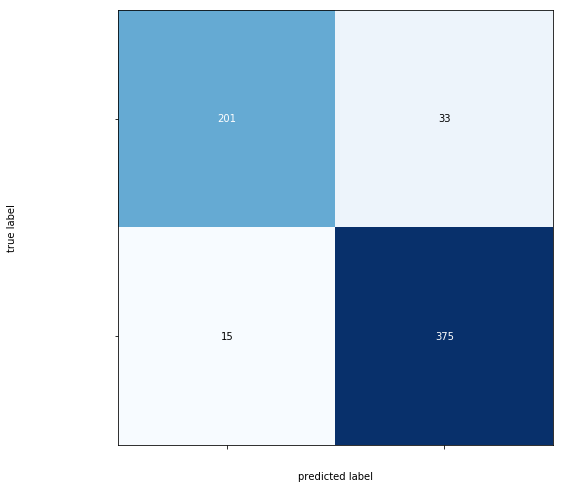

In [62]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
predictions = model.predict(test_d, batch_size=16)

predictions = np.argmax(predictions, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_l, axis=-1)

cm  = confusion_matrix(orig_test_labels, predictions)

plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16,color ='white')
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16,color ='white')
plt.show()

##Precision, Recall & F1-Score

In [64]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score_udemy= (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1_Score of the model is {:.2f}".format(f1_score_udemy))

Recall of the model is 0.96
Precision of the model is 0.92
F1_Score of the model is 0.94


## ROC Curve & AUC

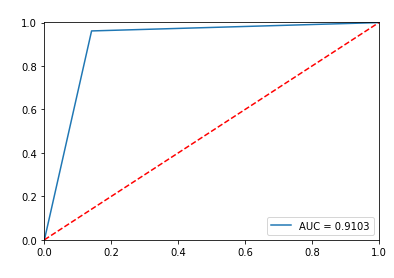

In [65]:
from sklearn.metrics import (precision_recall_curve, auc, roc_curve,
                             recall_score,
                             classification_report,
                             f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(orig_test_labels,predictions)
roc_auc = auc(fpr, tpr)

plt.title('ROC', color='white')
plt.plot(fpr,tpr,label='AUC = %0.4f'%roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001,1])
plt.ylim([0, 1.001])
plt.ylabel('True Pos Rate', color='white')
plt.xlabel('Flase Pos Rate', color='white')
plt.show()

##Display the x rays that were misclassified

In [0]:
falsified=[]
for i in range (624):
  if predictions[i] != orig_test_labels[i]:
    falsified.append(test_d[i])
falsified=np.array(falsified)

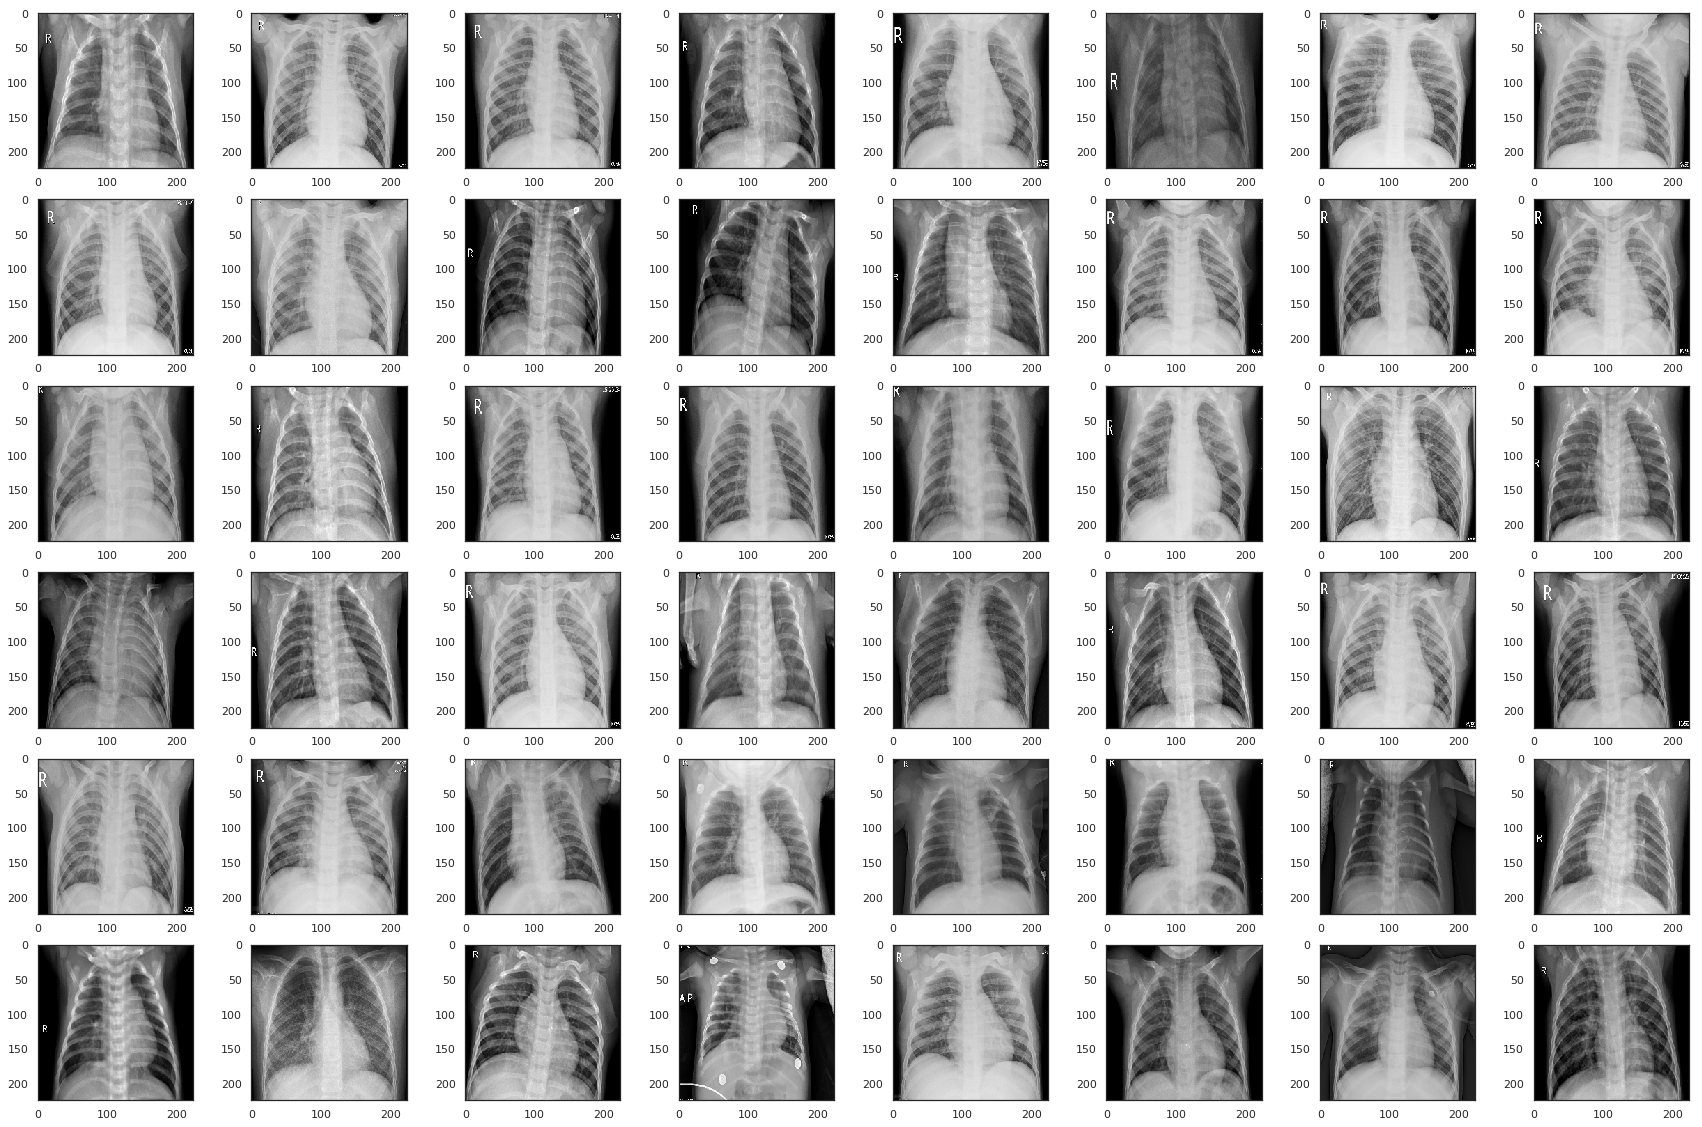

In [0]:
rows, columns = plt.subplots(6,8, figsize=(30,20))
for i in range(48):
  if i <8:
    columns[0,i%8].imshow(falsified[i])
  elif i >=8 and i<16:
    columns[1,i%8].imshow(falsified[i])
  elif i>=16 and i<24:
    columns[2,i%8].imshow(falsified[i])
  elif i>=24 and i<32:
    columns[3,i%8].imshow(falsified[i])
  elif i>=32 and i<40:
    columns[4,i%8].imshow(falsified[i])
  elif i>=40 and i<48:
    columns[5,i%8].imshow(falsified[i])
  elif i>=48 and i<49:
    columns[6,i%8].imshow(falsified[i])
plt.show()

##10-Fold Cross Validation
### From https://medium.com/@navmcgill/k-fold-cross-validation-in-keras-convolutional-neural-networks-835bed559d04

In [0]:
def evaluate_model(X_train, X_val, y_train, y_val):
  model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer= RMSprop(lr=0.00001, decay=1e-6))
  model.fit_generator(train_data_gen(X_train,y_train), 
                              epochs=8, verbose=1,
                              steps_per_epoch=nb_train_steps, 
                              validation_data= val_data_gen(X_validate,y_validate),
                              validation_steps=nb_valid_steps,
                              callbacks=[early_stop,lr_reduce],
                              #use class_weight to focus training on undersampled (Normal) Class
                              class_weight={0:1.0, 1:0.4})
  _, val_acc = model.evaluate(test_d, test_l, verbose = 1)
  model.load_weights("../content/drive/My Drive/Colab Notebooks/chest_xray/VGG16-Empty_Weights.h5")  
  return model, val_acc

In [0]:
n_folds = 10
cv_scores, model_history = list(), list()
for _ in range(n_folds):
    # split data
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.10, random_state = np.random.randint(1,1000))
    nb_train_steps = X_train.shape[0]//batch_size
    nb_valid_steps = X_validate.shape[0]//batch_size
    # evaluate model
    model,test_acc = evaluate_model(X_train, X_validate, y_train, y_validate)
    print('>%.3f' % test_acc)
    cv_scores.append(test_acc)
    model_history.append(model)
    
print('Estimated Accuracy %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

Epoch 1/8
293/293 [==============================] - 53s 180ms/step - loss: 0.1486 - acc: 0.8983 - val_loss: 0.1789 - val_acc: 0.9238
Epoch 2/8
293/293 [==============================] - 51s 174ms/step - loss: 0.1050 - acc: 0.9288 - val_loss: 0.1741 - val_acc: 0.9229
Epoch 3/8
293/293 [==============================] - 51s 174ms/step - loss: 0.0958 - acc: 0.9357 - val_loss: 0.0747 - val_acc: 0.9684
Epoch 4/8
293/293 [==============================] - 51s 173ms/step - loss: 0.0874 - acc: 0.9465 - val_loss: 0.0570 - val_acc: 0.9783
Epoch 5/8
293/293 [==============================] - 51s 173ms/step - loss: 0.0836 - acc: 0.9469 - val_loss: 0.1171 - val_acc: 0.9605
Epoch 6/8
293/293 [==============================] - 51s 172ms/step - loss: 0.0795 - acc: 0.9501 - val_loss: 0.1649 - val_acc: 0.9387

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
624/624 [==============================] - 3s 5ms/step
>0.885
Epoch 1/8
293/293 [==============================] - 

#Upload Image for prediction

Saving person907_virus_1563.jpeg to person907_virus_1563 (3).jpeg
pneumonia [1]


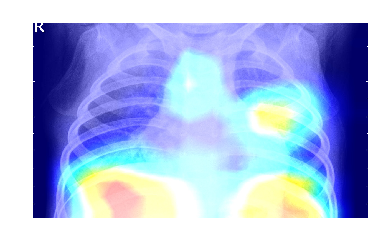

In [121]:
from google.colab import files
from keras.preprocessing import image
p_list = []

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  pred_img = image.load_img(fn, target_size=(224,224))
  pred_img = image.img_to_array(pred_img)
  if pred_img.shape[2]==1:
    pred_img = np.dstack([pred_img, pred_img, pred_img])
  pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
  pred_img = pred_img.astype(np.float32)/255.
  p_list.append(pred_img)
  p_list= np.array(p_list)
  #pred_img = np.expand_dims(pred_img,axis=0)
  #final_pred = np.vstack([pred_img])
  classes = model.predict(p_list, batch_size=16)
  classes= np.argmax(classes, axis=-1)
  if (classes ==1):
    print('pneumonia', classes)
    class_act_map(path)
  else:
    print(fn)
    print('normal',classes)

##Class Activation Mapping

In [0]:
def class_act_map(img_path):
    from keras.applications.vgg16 import decode_predictions
    import matplotlib.image as mpimg
    from keras import backend as K
    import matplotlib.pyplot as plt
    %matplotlib inline
    img=mpimg.imread(img_path)
    plt.imshow(img)
    from keras.preprocessing import image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    from keras.applications.vgg16 import preprocess_input
    x = preprocess_input(x)
    preds = model.predict(x)
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    import cv2
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = '/content/drive/My Drive/output.jpeg'
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.imshow(img)
    plt.axis('off')
    diag = ''
    if np.argmax ==0:
      diag= ('Normal')
    else:
      diag = ('Pneumonia')
    plt.title(diag,color='white')
    return None